In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## Load Data

In [44]:
scenario = "ssp245"
ensemble = "r1i1p1f1"

inpath = "/work/uo1227/u301557/DL/data/"

SIA = xr.open_dataset(f"{inpath}/sia/sia_nh_MPI-ESM1-2-LR_{ensemble}_hist_{scenario}.nc")
CO2 = xr.open_dataset(f"{inpath}/co2_emissions.nc")
SST = xr.open_dataset(f"{inpath}/sst/tos_MPI-ESM1-2-LR_{ensemble}_hist_{scenario}.nc")
GMST = xr.open_dataset(f"{inpath}/gmst/tas_MPI-ESM1-2-LR_{ensemble}_hist_{scenario}.nc")

In [13]:
print(GMST.tas.isel(time=slice(8,-1,12)).values[4:,0,0].shape)
print(GMST.tas.isel(time=slice(8,-1,12)).rolling(time=5).mean().values[4:,0,0].shape)

(247,)
(247,)


In [52]:
co2  = CO2[scenario].cumsum().values[100:]
sst  = SST.tos.isel(time=slice(8,-1,12)).values[:,0,0] #select september
gmst = GMST.tas.isel(time=slice(8,-1,12)).values[:,0,0]
sia  = SIA.sia_nh.isel(time=slice(8,-1,12)).values[:]

#gmst = GMST.tas.isel(time=slice(8,-1,12)).rolling(time=5).mean().values[4:,0,0]
#sia  = SIA.sia_nh.isel(time=slice(8,-1,12)).values[4:]

print(co2.shape,sst.shape,gmst.shape,sia.shape)

(251,) (251,) (251,) (251,)


In [55]:
if True:
    co2_norm  = (co2 - np.mean(co2))/np.std(co2)
    sst_norm  = (sst - np.mean(sst))/np.std(sst)
    gmst_norm = (gmst - np.mean(gmst))/np.std(gmst)
    sia_norm  = (sia - np.mean(sia))/np.std(sia)
else:
    co2_norm  = (co2)/np.max(co2)
    sst_norm  = (sst)/np.max(sst)
    gmst_norm = (gmst)/np.max(gmst)
    sia_norm  = (sia)/np.max(sia)

Vars = [co2_norm]

X = torch.tensor(np.stack(Vars,axis=1), dtype=torch.float32)
y = torch.tensor(sia_norm).view(-1, 1)
print(X.shape,y.shape)

N = 165#165
X_train = X[:N]
X_test  = X[N:]
y_train = y[:N]
y_test  = y[N:]


print(X_train.shape,X_test.shape)

torch.Size([251, 1]) torch.Size([251, 1])
torch.Size([165, 1]) torch.Size([86, 1])


torch.Size([161]) 160


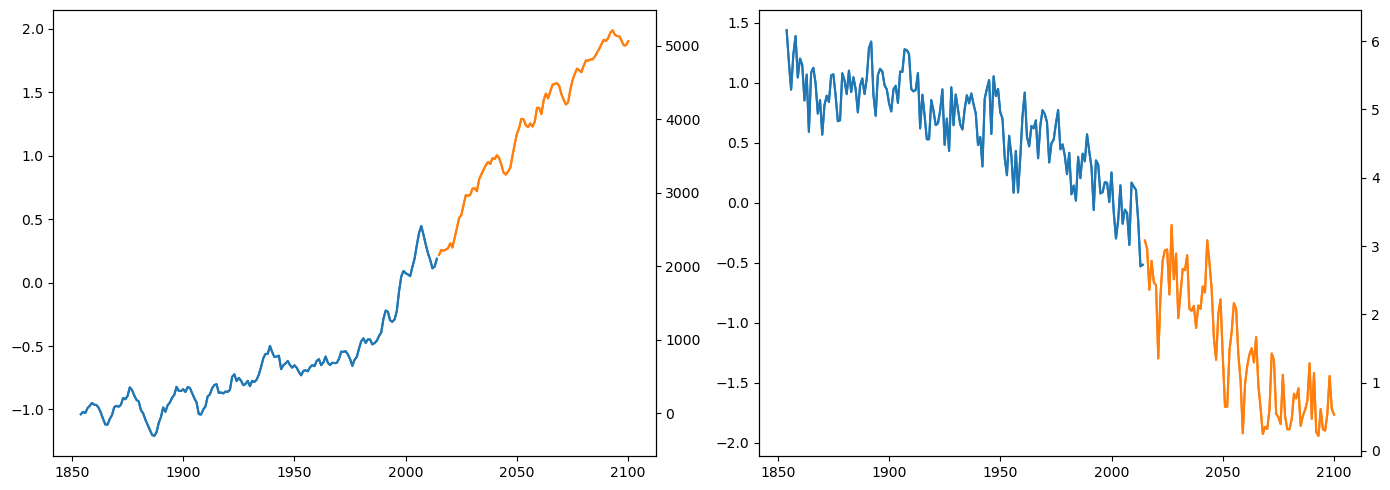

In [47]:
fig = plt.figure(figsize=(14,5),tight_layout=True)
axs = fig.subplots(1,X.shape[1]+1) 

for i in range(axs.shape[0]-1):
    print(X_train[:,i].shape, len(range(1855,2015)))
    axs[i].plot(range(1854,2015),X_train[:,i])
    axs[i].plot(range(2015,2101),X_test[:,i])
    ax2 = axs[i].twinx()
    ax2.plot(range(1854,2015),np.mean(co2)+X_train[:,i]*np.std(co2))
    ax2.plot(range(2015,2101),np.mean(co2)+X_test[:,i]*np.std(co2))
    
axs[-1].plot(range(1854,2015),y_train[:])
axs[-1].plot(range(2015,2101),y_test[:])
ax2 = axs[-1].twinx()
ax2.plot(range(1854,2015),np.mean(sia)+y_train[:]*np.std(sia))
ax2.plot(range(2015,2101),np.mean(sia)+y_test*np.std(sia))

plt.show()

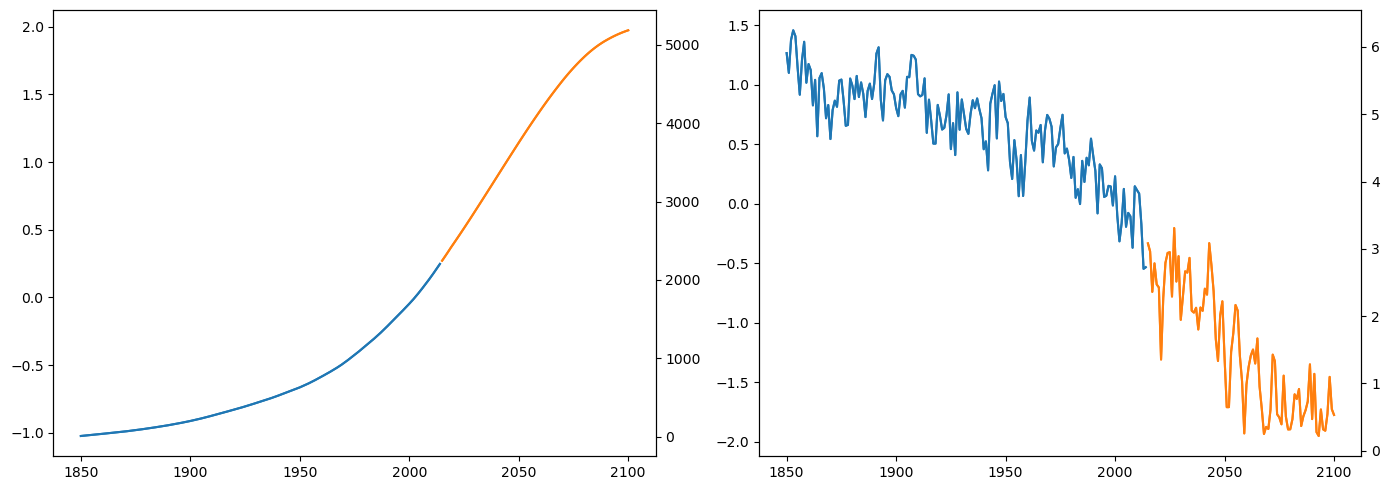

In [56]:
fig = plt.figure(figsize=(14,5),tight_layout=True)
axs = fig.subplots(1,X.shape[1]+1) 

for i in range(axs.shape[0]-1):
    axs[i].plot(range(1850,2015),X_train[:,i])
    axs[i].plot(range(2015,2101),X_test[:,i])
    ax2 = axs[i].twinx()
    ax2.plot(range(1850,2015),np.mean(co2)+X_train[:,i]*np.std(co2))
    ax2.plot(range(2015,2101),np.mean(co2)+X_test[:,i]*np.std(co2))
    
axs[-1].plot(range(1850,2015),y_train[:])
axs[-1].plot(range(2015,2101),y_test[:])
ax2 = axs[-1].twinx()
ax2.plot(range(1850,2015),np.mean(sia)+y_train[:]*np.std(sia))
ax2.plot(range(2015,2101),np.mean(sia)+y_test*np.std(sia))

plt.show()

In [31]:
def create_sequences2(x,y, sliding_window):
    inout_seq = []
    L = len(x)
    for i in range(L-sliding_window):
        
        seq_input = x[i:i+sliding_window]
        
        seq_output = y[i+sliding_window:i+sliding_window+1]
        inout_seq.append((seq_input ,seq_output))
    return inout_seq

In [32]:
sliding_window = 1
Train_inout_seq = create_sequences2(X_train,y_train, sliding_window)
Test_inout_seq  = create_sequences2(X_test, y_test, sliding_window)
print(Train_inout_seq[:1])

[(tensor([[-1.0378]]), tensor([[1.1721]]))]


In [167]:
# Define the sliding window parameters
window_size = 1  # Adjust the window size as desired
stride = 1  # Adjust the stride as desired

# Prepare the training data with the sliding window
train_input = []
train_output = []

for i in range(window_size, len(X_train)):
    train_input.append(X_train[i-window_size:i])
    train_output.append(y_train[i])
    
print(train_input[0])
# Convert the training data to PyTorch tensors
train_input = torch.stack([torch.tensor(x, dtype=torch.float32) for x in train_input])  # [seq_len, window_size, input_size]
train_output = torch.tensor(train_output, dtype=torch.float32).view(-1, 1) 

tensor([[-1.0034]])


/tmp/ipykernel_180257/744388888.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_input = torch.stack([torch.tensor(x, dtype=torch.float32) for x in train_input])  # [seq_len, window_size, input_size]


In [33]:
#Preparing the data for the network
class timeseries(Dataset):
    def __init__(self,seq):
        self.seq = seq
    def __getitem__(self,idx):
        x , y = self.seq[idx]
        return torch.tensor(x,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)
    def __len__(self):
        return len(self.seq)

dataset = timeseries(Train_inout_seq)
train_loader = DataLoader(dataset,shuffle=False,batch_size=32)

In [48]:
# Define your LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])  # Use the output of the last time step
        return output

In [34]:
# Define your LSTM model
class LSTMModel2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])  # Use the output of the last time step
        return output

In [57]:
# Set hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001


In [58]:
# Create the LSTM model
model = LSTMModel(1, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

w = 1
for epoch in range(num_epochs):
    # Forward pass
    for t in range(len(X_train)-w):
        output = model(X_train[t:t+w])
        #print()
        loss = criterion(output, y_train[t+w])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.1227
Epoch [20/100], Loss: 0.1089
Epoch [30/100], Loss: 0.1039
Epoch [40/100], Loss: 0.0993
Epoch [50/100], Loss: 0.0950
Epoch [60/100], Loss: 0.0911
Epoch [70/100], Loss: 0.0875
Epoch [80/100], Loss: 0.0845
Epoch [90/100], Loss: 0.0818
Epoch [100/100], Loss: 0.0797


In [39]:
# Create the LSTM model
model = LSTMModel(1, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

w = 1
for epoch in range(num_epochs):
    # Forward pass
    for t in range(len(train_input)):
        output = model(train_input[t])
        #print()
        loss = criterion(output, train_output[t])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

NameError: name 'train_input' is not defined

In [40]:
# Create the LSTM model
model = LSTMModel(sliding_window, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#w = 1
for epoch in range(num_epochs):
    for batch_idx, (seq,labels) in enumerate(train_loader):
        y_pred = model(seq.reshape(seq.shape[0],1,sliding_window))
        loss = criterion(labels,y_pred)

        # Backward and optimize
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

/tmp/ipykernel_1860646/967493367.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.1653
Epoch [20/100], Loss: 0.0749
Epoch [30/100], Loss: 0.0701
Epoch [40/100], Loss: 0.0694
Epoch [50/100], Loss: 0.0693
Epoch [60/100], Loss: 0.0693
Epoch [70/100], Loss: 0.0694
Epoch [80/100], Loss: 0.0694
Epoch [90/100], Loss: 0.0694
Epoch [100/100], Loss: 0.0694


In [41]:
with torch.no_grad():
    preds=[] #For saving model outputs
    orig = [] #For saving oroginal values
    for i in range (len(Train_inout_seq)):
        x,y = Train_inout_seq[i]
        #Extract from test_inout_seq. Remember to convert it to a tensor.
        #Pass through the model and save all the outputs in the "preds" list
        #Save all the ground truth values in the list "orig"
        input_series = torch.tensor(x,dtype=torch.float32)
        orig.append(y)
        y_pred = model(input_series.reshape(1,1,sliding_window))
        preds.append(y_pred.detach().numpy())

/tmp/ipykernel_1860646/3274181222.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_series = torch.tensor(x,dtype=torch.float32)


/tmp/ipykernel_1860646/3099773109.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(np.asarray(orig).reshape(-1,1)*np.std(sia)+np.mean(sia), label='original',linestyle='--')
/tmp/ipykernel_1860646/3099773109.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.asarray(orig).reshape(-1,1)*np.std(sia)+np.mean(sia), label='original',linestyle='--'

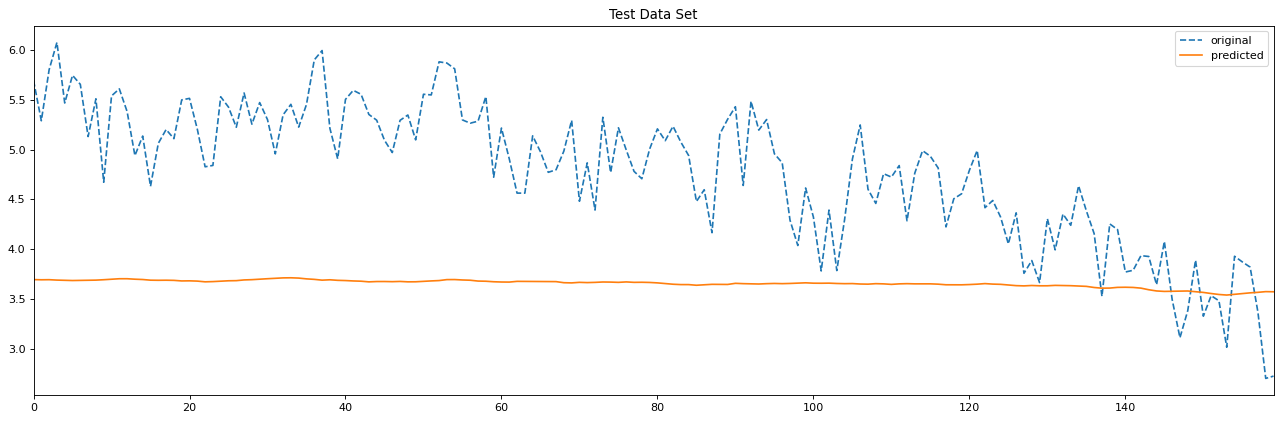

In [42]:
plt.figure(figsize=(20, 6), dpi=80)
#plt.plot(sc.inverse_transform(np.asarray(orig).reshape(-1,1)), label='original',linestyle='--')
#plt.plot(sc.inverse_transform(np.asarray(preds).reshape(-1,1)), label='predicted')
plt.plot(np.asarray(orig).reshape(-1,1)*np.std(sia)+np.mean(sia), label='original',linestyle='--')
plt.plot(np.asarray(preds).reshape(-1,1)*np.std(sia)+np.mean(sia), label='predicted')
#plt.plot((np.asarray(orig).reshape(-1,1)+ np.mean(sia_9))*np.std(sia_9), label='original',linestyle='--')
#plt.plot((np.asarray(preds).reshape(-1,1)+ np.mean(sia_9))*np.std(sia_9), label='predicted')
plt.title("Test Data Set")
plt.margins(x=0)
plt.legend()

In [59]:
# Predict the sea ice area for the test data
predicted_sea_ice_area = []

# Initialize the initial input with the last training data point
input_data = X_train[-1].unsqueeze(0)

# Iterate over the test CO2 emissions data and predict the sea ice area for each year
for i in range(len(X_test)):
    output = model(input_data)
    predicted_sea_ice_area.append(output.item())

    # Prepare the input for the next time step
    input_data = torch.tensor(X_test[i,:].unsqueeze(0), dtype=torch.float32)

# De-normalize the predicted sea ice area
predicted_sea_ice_area = (np.array(predicted_sea_ice_area)* np.std(sia) + np.mean(sia))


/tmp/ipykernel_1860646/3795959306.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(X_test[i,:].unsqueeze(0), dtype=torch.float32)


In [171]:
X_test.shape,X_test[0,:]

(torch.Size([86, 1]), tensor([0.3180]))

In [60]:
# Predict the sea ice area for the test data
train_yhat = []

# Iterate over the test CO2 emissions data and predict the sea ice area for each year
for i in range(len(X_train)):
    output = model(X_train[i].unsqueeze(0))
    train_yhat.append(output.item())

# De-normalize the predicted sea ice area
train_yhat = (np.array(train_yhat)* np.std(sia) + np.mean(sia))


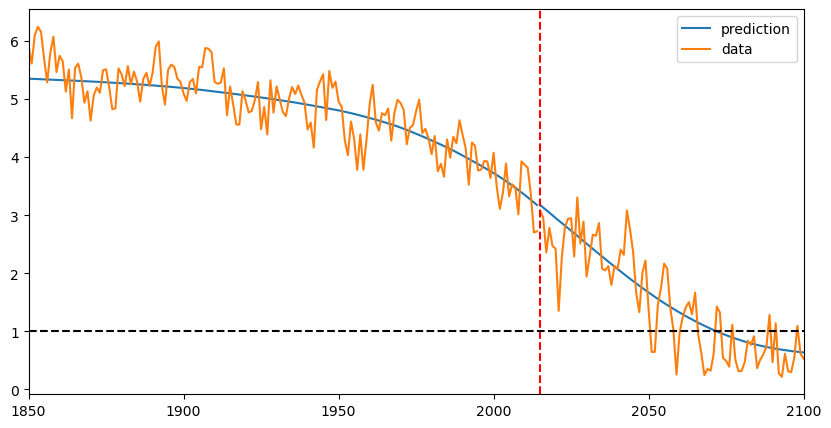

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1)

ax.plot(range(1850,2015),train_yhat,label="prediction",c='#1f77b4')#, '#ff7f0e')
ax.plot(range(1850,2015),y_train*np.std(sia)+np.mean(sia),label="data",c='#ff7f0e')
ax.plot(range(2015,2101),predicted_sea_ice_area,c='#1f77b4')
ax.plot(range(2015,2101),y_test*np.std(sia)+np.mean(sia),c='#ff7f0e')
#ax.set_ylim(0,7)

ax.axvline(x=2015, c='r', linestyle='--') #size of the training set
ax.axhline(y=1, c='black', linestyle='--') #size of the training set
ax.margins(x=0)
ax.legend()
plt.show()